# 4.4 - Redes convolucionales

En este notebook, exploraremos cómo resolver un problema de **clasificación de imágenes** utilizando una red convolucional (CNN).

Como sabrás, estas redes se componen de capas convolucionales que son especialmente efectivas para procesar datos con una estructura de cuadrícula, como las imágenes.

Las redes convolucionales aplican filtros para extraer características relevantes de las imágenes y, a través de operaciones como la convolución y el pooling, pueden detectar patrones locales que son invariables a la traslación.

Para crear este tipo de redes, PyTorch nos prporciona, [entre otras](https://pytorch.org/docs/stable/nn.html#convolution-layers), las siguientes capas: 
* **`torch.nn.Conv1d`**: Capa que aplica una Convolución 1D.
* **`torch.nn.Conv2d`**: Capa que aplica una Convolución 2D.
* **`torch.nn.Conv3d`**: Capa que aplica una Convolución 3D.

Además de las capas convolucionales, también necesitamos [otras capas](https://pytorch.org/docs/stable/nn.html#pooling-layers) y funciones para construir una CNN completa:

* **`torch.nn.MaxPool2d`**: Capa que aplica una operación de Max Pooling 2D. También existen versiones 1D y 3D, así como con otras funciones como la media (AvgPool).
* **`torch.nn.Flatten`**: Capa que aplana la entrada, convirtiéndola en una dimensión.
* **`torch.nn.AdaptiveAvgPool2d`**: Capa que aplica una operación de Global Average Pooling 2D. Como sucedía en el pooling normal, existen varias versiones.




## Conjunto de datos

Utilizaremos el conjunto [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) ya utilizado en prácticas anteriores. 

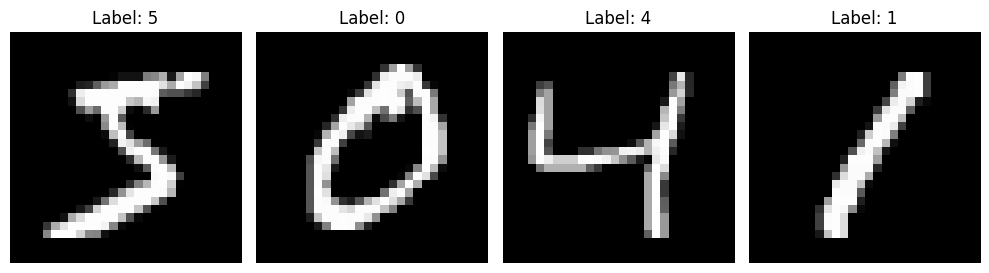

Como puedes ver en la figura, este conjunto posee imágenes en escala de grises con números del 0 al 9 escritos a mano por personas.

Cada una de estas imágenes tiene una resolución de 28x28 píxels. Al ser en escala de grises, cada imagen será un tensor de 1x28x28.

Crearemos, por tanto una red que, a partir de una imagen del conjunto, intente predecir el dígito que aparece reflejado en esta.


### Descargar conjunto

La librería ``torchvision`` posee multiples herramientas que facilitan la resolución de problemas con imágenes.

Una de estas herramientas es la submódulo ``datasets``, que incluye conjuntos de datos populares y utilidades para cargarlos.


In [ ]:
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms

# Fijar la semilla para obtener reproducibilidad y crear variable device
seed = 42
torch.manual_seed(seed)  # Fijar semilla de PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definimos una transformación que convierte las imágenes a tensores.
# La transformación ToTensor() convierte una imagen PIL en un tensor de PyTorch.
# El compose permite concatenar múltiples transformaciones, en este caso solo aplicamos una.
transform = transforms.Compose([transforms.ToTensor()])

# Descargamos el dataset indicando donde almacenarlo, la partición y las transformaciones
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Creamos un conjunto de validación, dado que no viene por defecto
mnist_train, mnist_val = random_split(mnist_train, (0.8, 0.2))

batch_size = 16

# Tras descargar, ya tentemos un objeto Dataset, por lo que necesitamos un DataLoader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

### Análisis de datos

Para este problema, vamos a visualizar algunos de los ejemplos así como comprobar cada una de sus dimensiones.

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura con 5 varias imágenes del conjunto
plt.figure(figsize=(10, 2))
# Para extraer ejemplos de un DataLoader, necesitamos un iterador
iterator = iter(train_loader)
# Pedimos el siguiente batch al iterador (y nos dará batch_size ejemplos)
image, label = next(iterator)
# Creamos un gráfico para mostrar batch_size ejemplos
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(image[i][0].squeeze(), cmap='gray')
    plt.title(f"{label[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Vamos a ver el tamaño de una de las imágenes
print(image[i].size())
# Y su rango de valores
print(image[i].max(), image[i].min())

Como puedes ver, este conjunto ya viene normalizado en el rango [0, 1]. 

Como sabrás, típicamente las imágenes se mueven en el rango [0-255], el cual habría que normalizar o estandarizar antes de introducir al modelo.

## 4.4.2. - Modelo


Vamos a crear un modelo muy sencillo con las siguientes capas:
* Convolucion 2D con 3 filtros de 3x3.
* Función de activación ReLU.
* MaxPooling2D.
* Capa Flatten para transformar el volumen de salida de la capa anterior en un vector.
* Capa lineal de salida tamaño 10.

In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 14 * 14, 10)  # 32 canales, 14x14 tamaño de imagen después de la capa de pooling

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)  # Aplicamos convolución, ReLU y max pooling
        x = self.flatten(x)
        x = self.fc1(x)
        return x
    
learning_rate = 0.0005
num_epochs = 5

# Creamos el modelo
model = SimpleCNN()
model.to(device)
criterion = nn.CrossEntropyLoss() # Recuerda que ya aplica la softmax
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Imprimir la arquitectura
print(model)

Los tamaños de las entradas, salidas y número de parámetros de las redes convolucionales son más difíciles de ver, para entender mejor lo que pasa en nuestro modelo vamos a utilizar la librería ``torchsummary``.

Para instalarla:
``` shell
pip install torch-summary

```

Utilizarla es muy sencillo, solo tenemos que dar al método `summary` el modelo y el tamaño que tendrá un ejemplo de nuestro conjunto.

Como resultado veremos una lista con cada una de las capas del modelo, el volumen que producen en la salida (output shape) y el número de parámetros que se aprenden en ella. 

También veremos un resumen de todos los parámetros del modelo y cuales de ellos se pueden entrenar.

In [ ]:
from torchsummary import summary

summary(model, (1, 28, 28))

Para entrenar el modelo, podemos utilizar los métodos creados en prácticas anteriores.

In [ ]:
import time 

# Función para calcular la precisión (accuracy) en un conjunto de datos
def calculate_accuracy(model, data_loader, K=1):
    model.eval()  # Configuramos el modelo en modo evaluación (no se actualizan los pesos)
    correct = 0  # Contador para predicciones correctas
    total = 0  # Contador para el número total de ejemplos

    with torch.no_grad():  # Desactivamos el cálculo de gradientes
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Hacemos una predicción con el modelo
            # Obtenemos las probabilidades de las clases (Top-K)
            topk = outputs.topk(K, dim=1)[1]
            # Creamos una máscara que indica si la etiqueta correcta está entre las top-K predicciones
            correct_mask = topk.eq(targets.view(-1, 1).expand_as(topk))
            correct += correct_mask.sum().item()  # Contamos las predicciones correctas
            total += targets.size(0)  # Contamos el número total de ejemplos

    accuracy = correct / total  # Calculamos la precisión como el porcentaje de predicciones correctas
    return accuracy

# Función de entrenamiento y validación
def train_model(model, optimizer, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        start_time = time.time()  # Registramos el tiempo de inicio de la epoch

        total_train_loss = 0  # Inicializamos la variable para acumular la pérdida de entrenamiento
        total_val_loss = 0    # Inicializamos la variable para acumular la pérdida de validación

        # Entrenamiento
        model.train() # Configuramos el modelo en modo entrenamiento
        for inputs, targets in train_loader:  # Iteramos sobre los datos de entrenamiento
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Reseteamos los gradientes del optimizador
            outputs = model(inputs)  # Hacemos una predicción con el modelo
            loss = criterion(outputs, targets)  # Calculamos la pérdida entre la predicción y el objetivo
            loss.backward()  # Calculamos los gradientes (backpropagation)
            optimizer.step()  # Actualizamos los pesos del modelo según el optimizador
            total_train_loss += loss.item()  # Acumulamos la pérdida de esta iteración

        # Calculamos la precisión para el conjunto de entrenamiento
        train_accuracy = calculate_accuracy(model, train_loader)
        
        # Validación
        model.eval()  # Configuramos el modelo en modo evaluación (no se actualizan los pesos)
        with torch.no_grad():  # Desactivamos el cálculo de gradientes para ahorrar memoria y mejorar la velocidad
            for inputs, targets in val_loader:  # Iteramos sobre los datos de validación
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Hacemos una predicción con el modelo
                loss = criterion(outputs, targets)  # Calculamos la pérdida para validación
                total_val_loss += loss.item()  # Acumulamos la pérdida de esta iteración

        # Calculamos la precisión para el conjunto de validación
        val_accuracy = calculate_accuracy(model, val_loader)
        val_accuracy_3 = calculate_accuracy(model, val_loader, K=3)

        # Calculamos el tiempo total de la epoch
        epoch_time = time.time() - start_time  

        # Imprimimos las estadísticas de la epoch: pérdida de entrenamiento, validación, precisión y tiempo
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {total_train_loss/len(train_loader):.4f}, '
              f'Val Loss: {total_val_loss/len(val_loader):.4f}, '
              f'Train T1 Accuracy: {train_accuracy:.4f}, '
              f'Val T1 Accuracy: {val_accuracy:.4f}, '
              f'Val T3 Accuracy: {val_accuracy_3:.4f}, '
              f'Time: {epoch_time:.2f} sec')

# Entrenar el modelo CNN
print(f"Entrenando CNN en {device}...")
train_model(model, optimizer, train_loader, val_loader, num_epochs)

## 4.4.3. - Ejercicios

> **EJERCICIO:** Crea el código necesario para dibujar un batch de imágenes de test junto con su predicción (incluida la probabilidad).

> **EJERCICIO:** Utiliza [este modelo](https://huggingface.co/farleyknight-org-username/vit-base-mnist) de HugginFace entrenado para la misma tarea y verifica su funcionamiento con la primera imagen de test.

> OJO, si utilizas pipelines, igual tienes que transformar una imagen de tensor a imagen PIL con este método:

```python
from torchvision.transforms.functional import to_pil_image

image_PIL = to_pil_image(image_tensor)
```

> **EJERCICIO:** Crea, entrena y evalúa un modelo capaz de resolver el problema [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

```python
# Descarga del dataset
dataset_train = datasets.CIFAR10(...)
# Un vector con los nombres de las clases
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

```